In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
C = torch.randn((27, 2))

In [9]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [10]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [11]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [12]:
h

tensor([[-0.6730,  0.9976,  0.4594,  ..., -0.9992,  0.2087,  0.9110],
        [-0.5167,  0.9786, -0.5265,  ..., -0.9697,  0.4070, -0.1526],
        [ 0.1774,  0.9993,  0.9877,  ..., -0.9668,  0.5773,  0.1620],
        ...,
        [ 0.4328,  0.4951, -0.1907,  ...,  0.9845, -0.1978,  0.3358],
        [ 0.9415, -0.9492, -0.9526,  ...,  0.9283,  0.3463,  0.6270],
        [-0.6181,  0.9998,  0.0586,  ...,  0.9937, -0.7274, -0.9422]])

In [13]:
h.shape

torch.Size([228146, 100])

In [14]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [15]:
logits = h @ W2 + b2

In [16]:
logits.shape

torch.Size([228146, 27])

In [17]:
counts = logits.exp()

In [18]:
prob = counts / counts.sum(1, keepdims=True)

In [19]:
prob.shape

torch.Size([228146, 27])

In [20]:
Y.shape

torch.Size([228146])

In [21]:
loss = -prob[torch.arange(32), Y[:32]].log().mean()
loss

tensor(14.9259)

In [22]:
# ------------ now made respectable :) ---------------

In [23]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [53]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.rand((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [25]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [54]:
for p in parameters:
  p.requires_grad = True

In [27]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [55]:
lri = []
lossi = []
stepi = []
step = 0

In [67]:
for i in range(200000):
  step += 1
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (100,))
  
  # forward pass
  emb = C[Xtr[ix]] # (64, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (64, 200)
  logits = h @ W2 + b2 # (64, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.01 * (1 + 1e-8 * step)
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(step)
  lossi.append(loss.log().item())

#print(loss.item())

In [63]:
print(loss.item())

2.1757097244262695


In [58]:
len(lossi)

200000

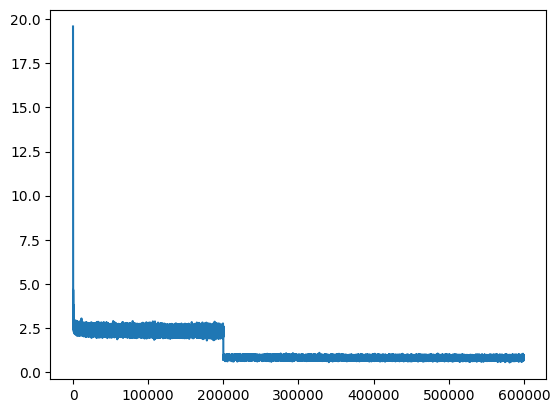

In [68]:
plt.plot(stepi, lossi)

In [33]:
C.shape

torch.Size([27, 10])

In [34]:
emb.shape

torch.Size([100, 3, 10])

In [69]:
emb = C[Xtr] # (Xtr.shape[0], 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (64, 100)
logits = h @ W2 + b2 # (64, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2370, grad_fn=<NllLossBackward0>)

In [70]:
emb = C[Xdev] # (64, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (64, 100)
logits = h @ W2 + b2 # (64, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2429, grad_fn=<NllLossBackward0>)

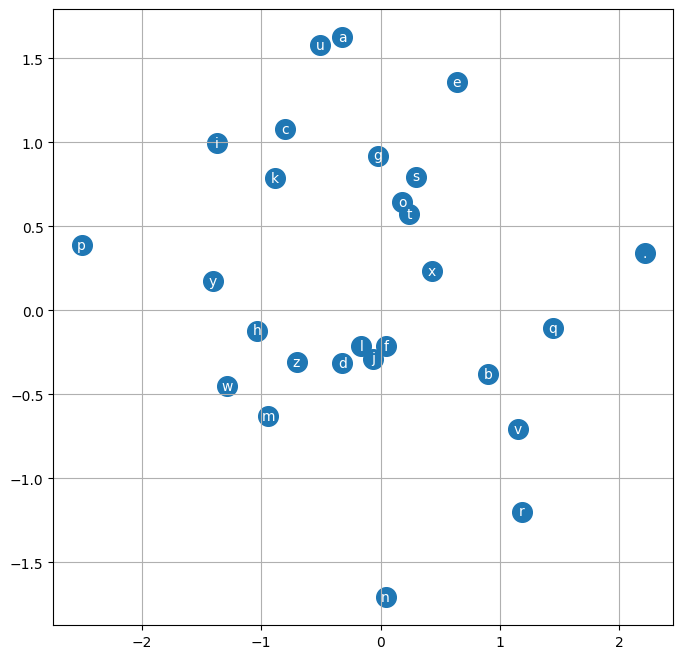

In [37]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [38]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [39]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [40]:


# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mria.
mayan.
seel.
ndheyah.
rethan.
endra.
gra.
chedielii.
shi.
jelleie.
sestanar.
kayzioh.
kalin.
shubrrishiries.
kin.
renel.
panteulan.
breyed.
riyahli.
els.


The best result of loss that I can get from tuning the hyperparameters is 2.1181 for training set and 2.1556 for validation set. 
n_embed = 64
n_hidden = 200

If the initialization is uniform, the initial loss is much smaller. The final loss can be similar to previous setup and a bit higher, ~2.3.

Setting a learning rate decay, increasing n_embed, and increasing the number of iterations can improve the model performance a bit.